In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.fft import fft2, fftshift, ifft2, ifftshift, fft, ifft, fftfreq
import skimage.io as io
import cv2                                                     # for filtering vector fields
from skimage.morphology import opening, disk, dilation         # morphology operations
%matplotlib notebook
import matplotlib.pyplot as plt  # for plotting everything
import numpy.matlib as matlib
from skimage.transform import rotate, resize
import scipy.stats as st
import pandas as pd
from FFT_Alignment_tools import *

In [2]:
# read in the images

Collagen = io.imread("CFAOVAD3 FNAF488 CD31 AF647 Th1 CMTMR_A01_G009_Collagen.tif")
FN = io.imread("CFAOVAD3 FNAF488 CD31 AF647 Th1 CMTMR_A01_G009_FN.tif")
print(FN.shape)
print(Collagen.shape)


(28, 16, 512, 512)
(28, 16, 512, 512)


In [3]:
# calculate the local orientation of each ECM matrix
FN_vs_Collagen = []
FN_vs_random = []
Collagen_vs_random = []
FN_vs_Collagenpermutation = []
N_pts_zplane = []

N_rows, N_cols = FN.shape[2:]
window_size = 33
radius = int(np.floor((window_size) / 2))
overlap = 0.5
rpos = np.arange(radius,N_rows-radius,int(window_size * overlap))
cpos = np.arange(radius,N_cols-radius,int(window_size * overlap))
FN_theta_stack = np.zeros([FN.shape[1], len(rpos), len(cpos)])

t=0
for z in np.arange(0,FN.shape[1]):
    FN_x, FN_y, FN_u, FN_v, FN_theta, FN_ecc = image_local_order(FN[t,z,:,:])
    Collagen_x, Collagen_y, Collagen_u, Collagen_v, Collagen_theta, Collagen_ecc = image_local_order(Collagen[t,z,:,:])
    random_theta = np.random.rand(len(FN_theta)) * np.pi
    mask = np.array(FN_ecc) > 0.33
    Collagen_permutation = np.random.permutation(Collagen_theta[mask])
    FN_vs_Collagen.append(np.mean((np.cos(FN_theta[mask] - Collagen_theta[mask]))**2))
    FN_vs_random.append(np.mean((np.cos(FN_theta[mask] - random_theta[mask]))**2))
    Collagen_vs_random.append(np.mean((np.cos(Collagen_theta[mask] - random_theta[mask]))**2))
    FN_vs_Collagenpermutation.append(np.mean((np.cos(FN_theta[mask] - Collagen_permutation))**2))
    N_pts_zplane.append(np.sum(mask))
    
    FN_theta_stack[z,:,:] = np.reshape(FN_theta,(len(rpos),len(cpos)))
    
    if z == 7:
        FN_plane7 = FN_theta[mask]
        Collagen_plane7 = Collagen_theta[mask]
        Collagen_permutation_plane7 = Collagen_permutation
        Random_plane7 = random_theta[mask]
        x = FN_x.copy()
        y = FN_y.copy()
        u = FN_u.copy()
        v = FN_v.copy()
        xc = Collagen_x.copy()
        yc = Collagen_y.copy()
        uc = Collagen_u.copy()
        vc = Collagen_v.copy()
        FN_ecc_plane7 = FN_ecc.copy()
        FN_theta_plane7 = FN_theta.copy()
        mask_plane7 = mask.copy()
    

<IPython.core.display.Javascript object>


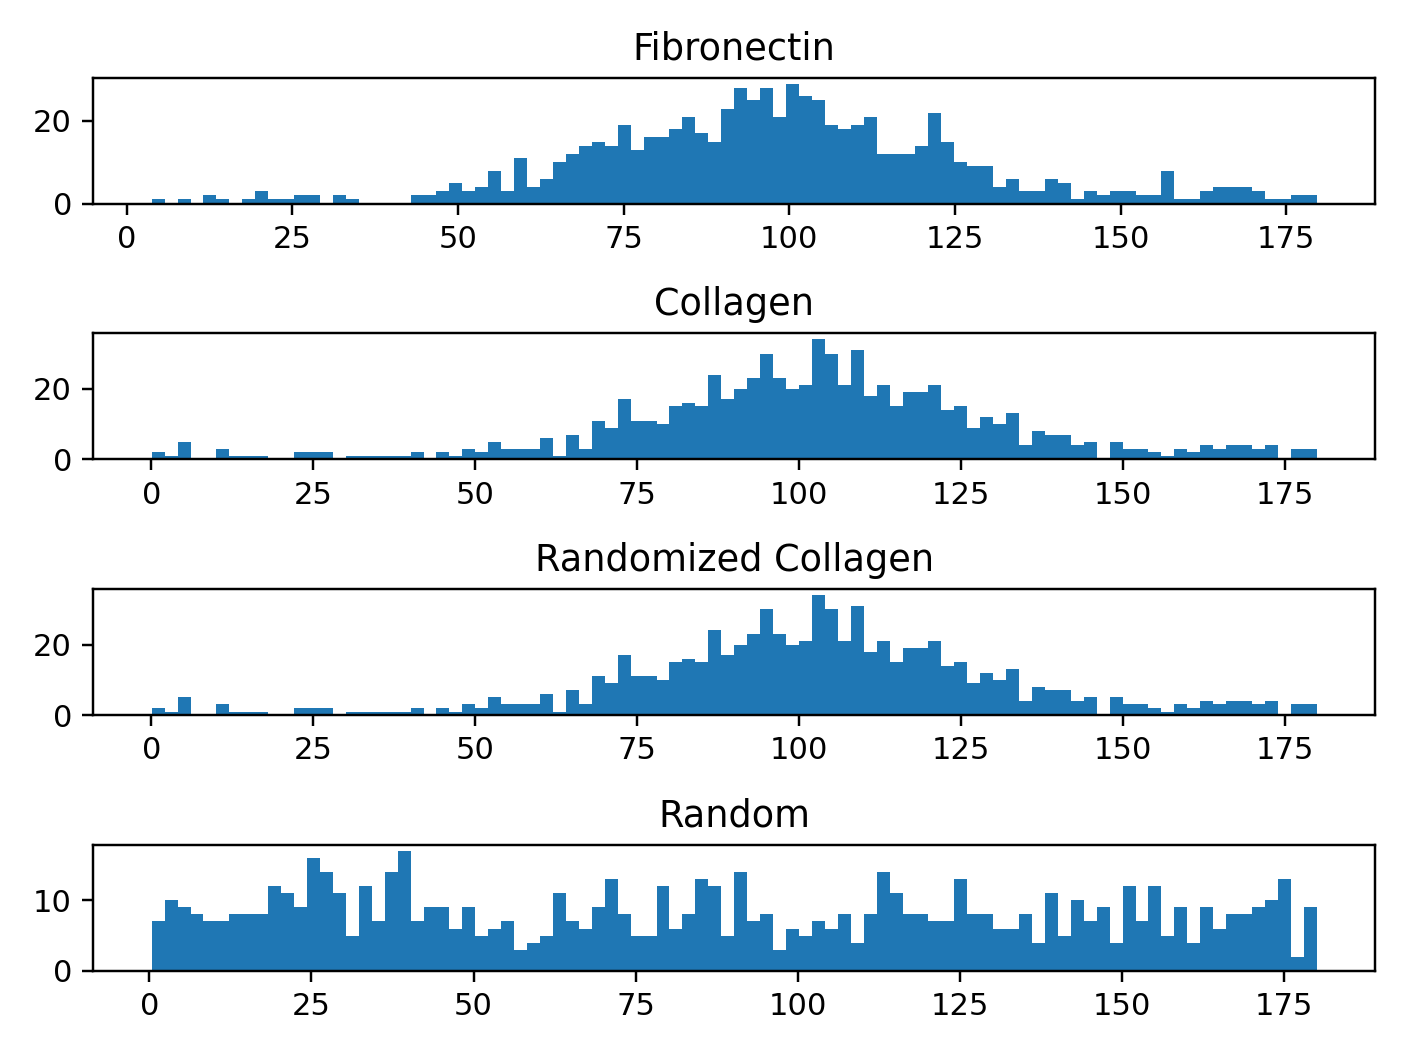

<IPython.core.display.Javascript object>


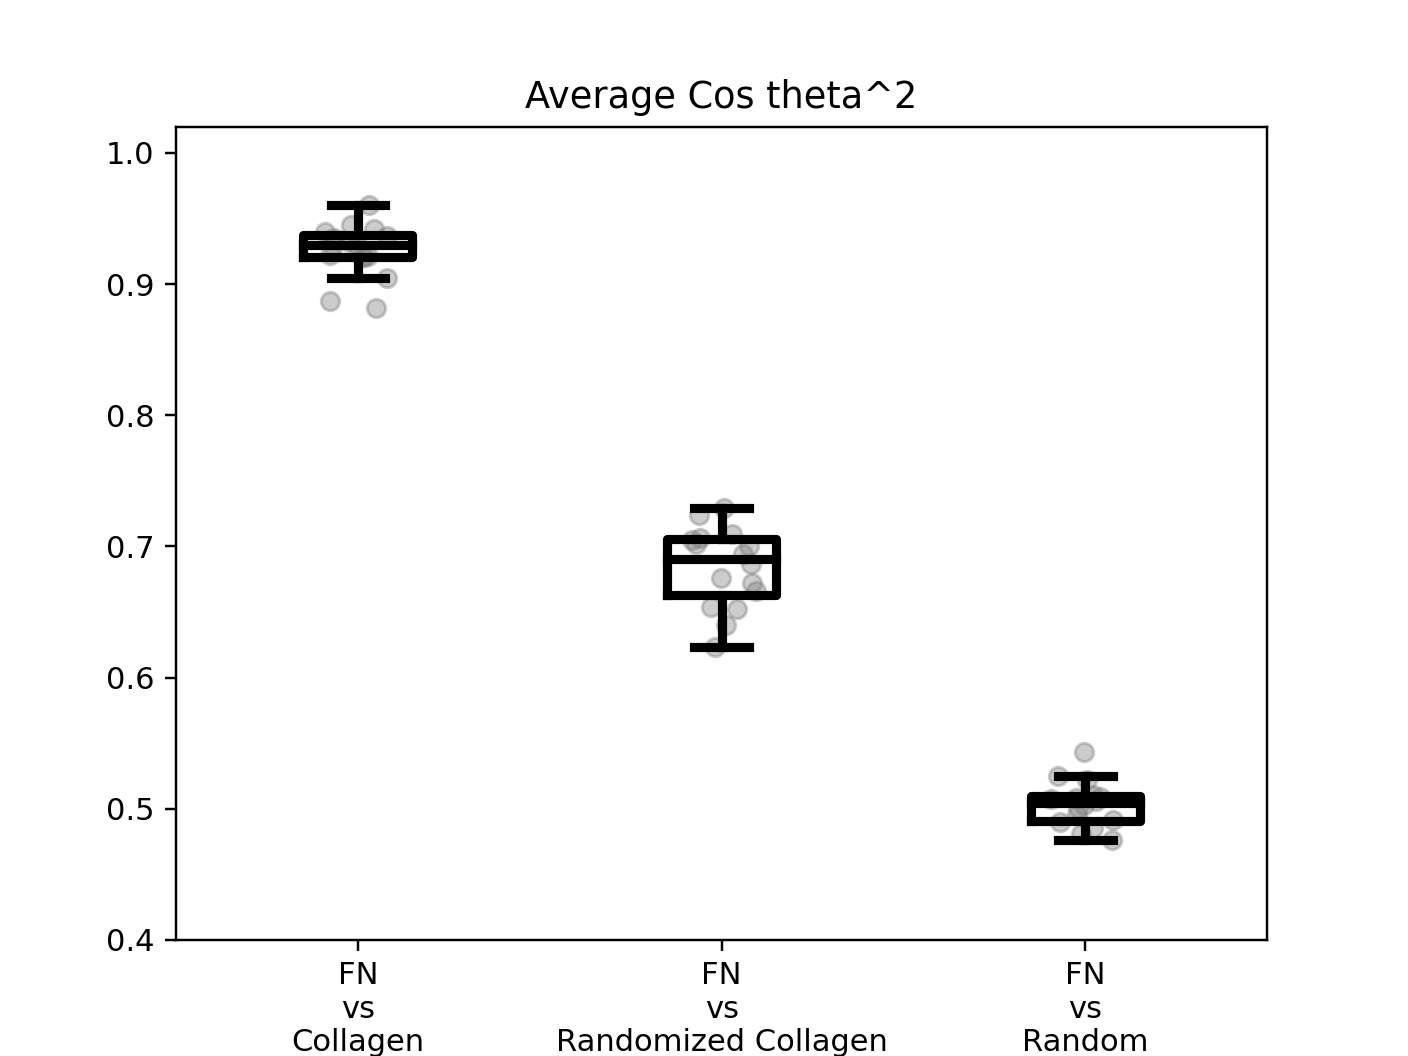

P-value for FN_vs_Collagen compared to FN_vs_RandomizedCollagen is 7.724550868747958e-07
P-value for FN_vs_Collagen compared to FN_vs_Random is 7.724550868747958e-07
P-value for FN_vs_RandomizedCollagen compared to FN_vs_Random is 7.724550868747958e-07


In [4]:
# make plots of the distrutions and the compared orientations
# to show distribution
dist_fig, dist_ax = plt.subplots(nrows=4)
dist_ax[0].hist(FN_plane7 * 180/np.pi, bins=90)
dist_ax[0].set_title('Fibronectin')
dist_ax[1].hist(Collagen_plane7 * 180/np.pi, bins=90)
dist_ax[1].set_title('Collagen')
dist_ax[2].hist(Collagen_permutation_plane7 * 180/np.pi, bins=90)
dist_ax[2].set_title('Randomized Collagen')
dist_ax[3].hist(Random_plane7 * 180/np.pi, bins=90)
dist_ax[3].set_title('Random')
dist_fig.tight_layout()
dist_fig.show()

# dist_fig.savefig('Angle_distributions.eps', format='eps')

# all data lumped together into a single list for boxplot
angles = []

angles.append(FN_vs_Collagen)
angles.append(FN_vs_Collagenpermutation)
angles.append(FN_vs_random)
# angles.append(Collagen_vs_random)

boxprops = dict(linewidth=3, color='k')
medianprops = dict(linewidth=3, color='k')
whiskerprops= dict(linewidth=3, color='k')
capprops = dict(linewidth=3, color='k')

anglecomp_fig, anglecomp_axes = plt.subplots()
anglecomp_axes.plot(np.ones(len(angles[0])) + np.random.random(len(angles[0]))/5 - .1,angles[0],'o', color='grey',  alpha = 0.4)
anglecomp_axes.plot(2*np.ones(len(angles[1])) + np.random.random(len(angles[1]))/5 - .1,angles[1],'o', color='grey', alpha = 0.4)
anglecomp_axes.plot(3*np.ones(len(angles[2])) + np.random.random(len(angles[2]))/5 - .1,angles[2],'o', color='grey', alpha = 0.4)
# anglecomp_axes.plot(4*np.ones(len(angles[3])) + np.random.random(len(angles[3]))/5 - .1,angles[3],'o', color='grey', alpha = 0.4)
anglecomp_axes.boxplot(angles, labels=['FN\nvs\nCollagen','FN\nvs\nRandomized Collagen','FN\nvs\nRandom'], showfliers=False, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops = capprops)
anglecomp_axes.set_title('Average Cos theta^2')
anglecomp_axes.set_ylim([0.4, 1.02])
anglecomp_fig.show()
# anglecomp_fig.savefig('Cos_squared_boxplot.eps', format='eps')

stat1, p1 = st.mannwhitneyu(FN_vs_Collagen, FN_vs_Collagenpermutation)
stat2, p2 = st.mannwhitneyu(FN_vs_Collagen, FN_vs_random)
stat3, p3 = st.mannwhitneyu(FN_vs_Collagenpermutation, FN_vs_random)

print("P-value for FN_vs_Collagen compared to FN_vs_RandomizedCollagen is {}".format(p1))
print("P-value for FN_vs_Collagen compared to FN_vs_Random is {}".format(p2))
print("P-value for FN_vs_RandomizedCollagen compared to FN_vs_Random is {}".format(p2))

<IPython.core.display.Javascript object>


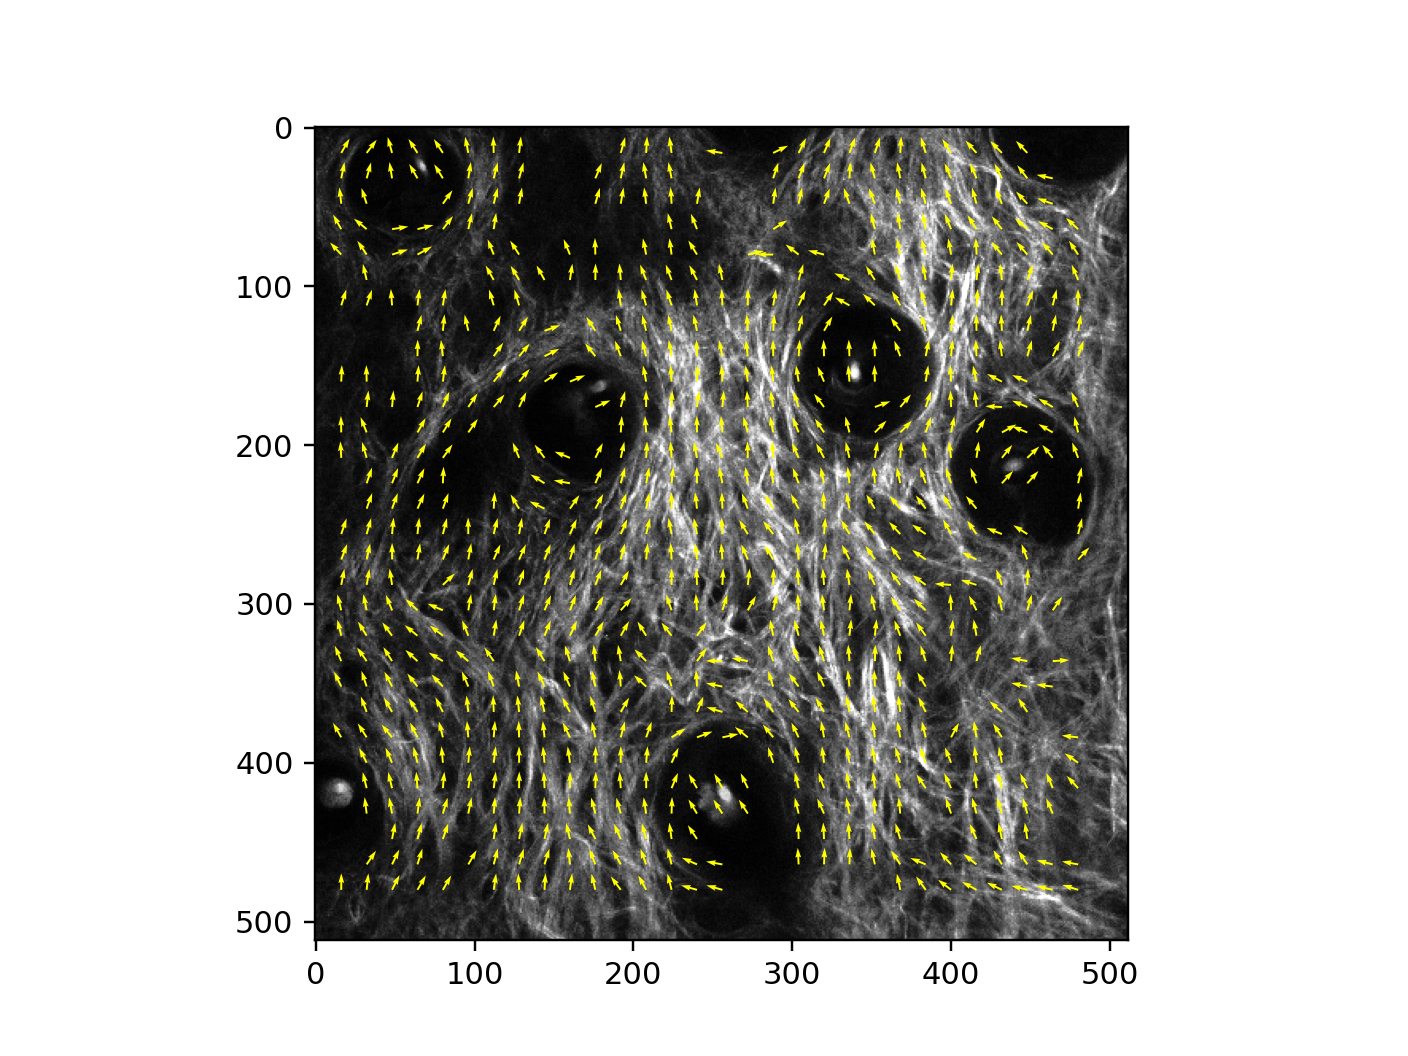

<IPython.core.display.Javascript object>


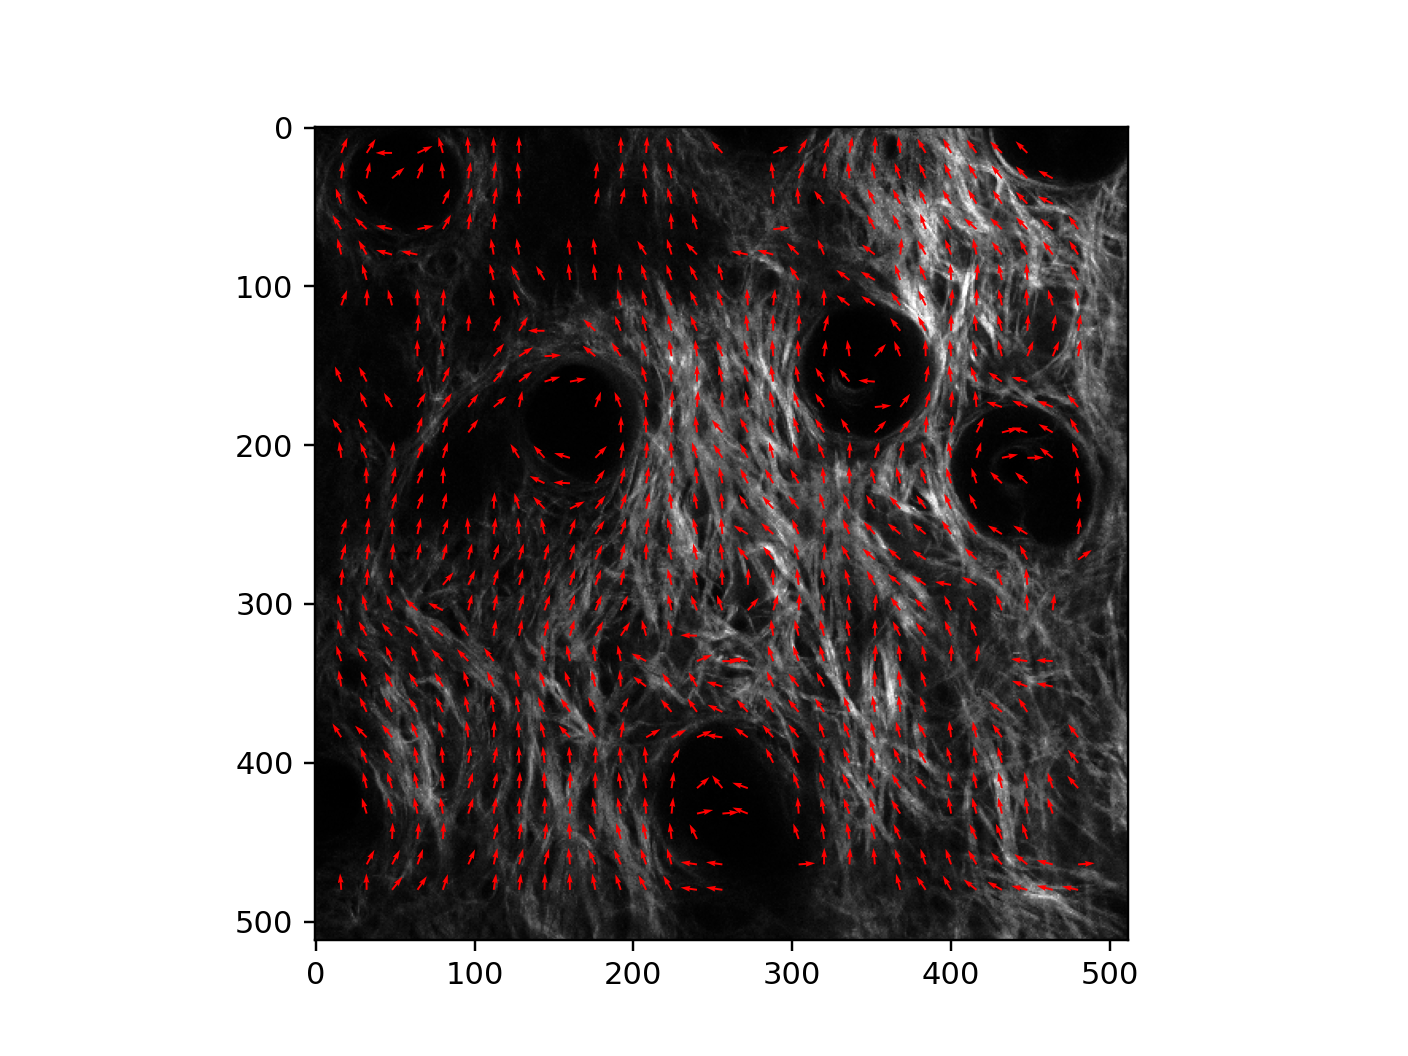

<IPython.core.display.Javascript object>


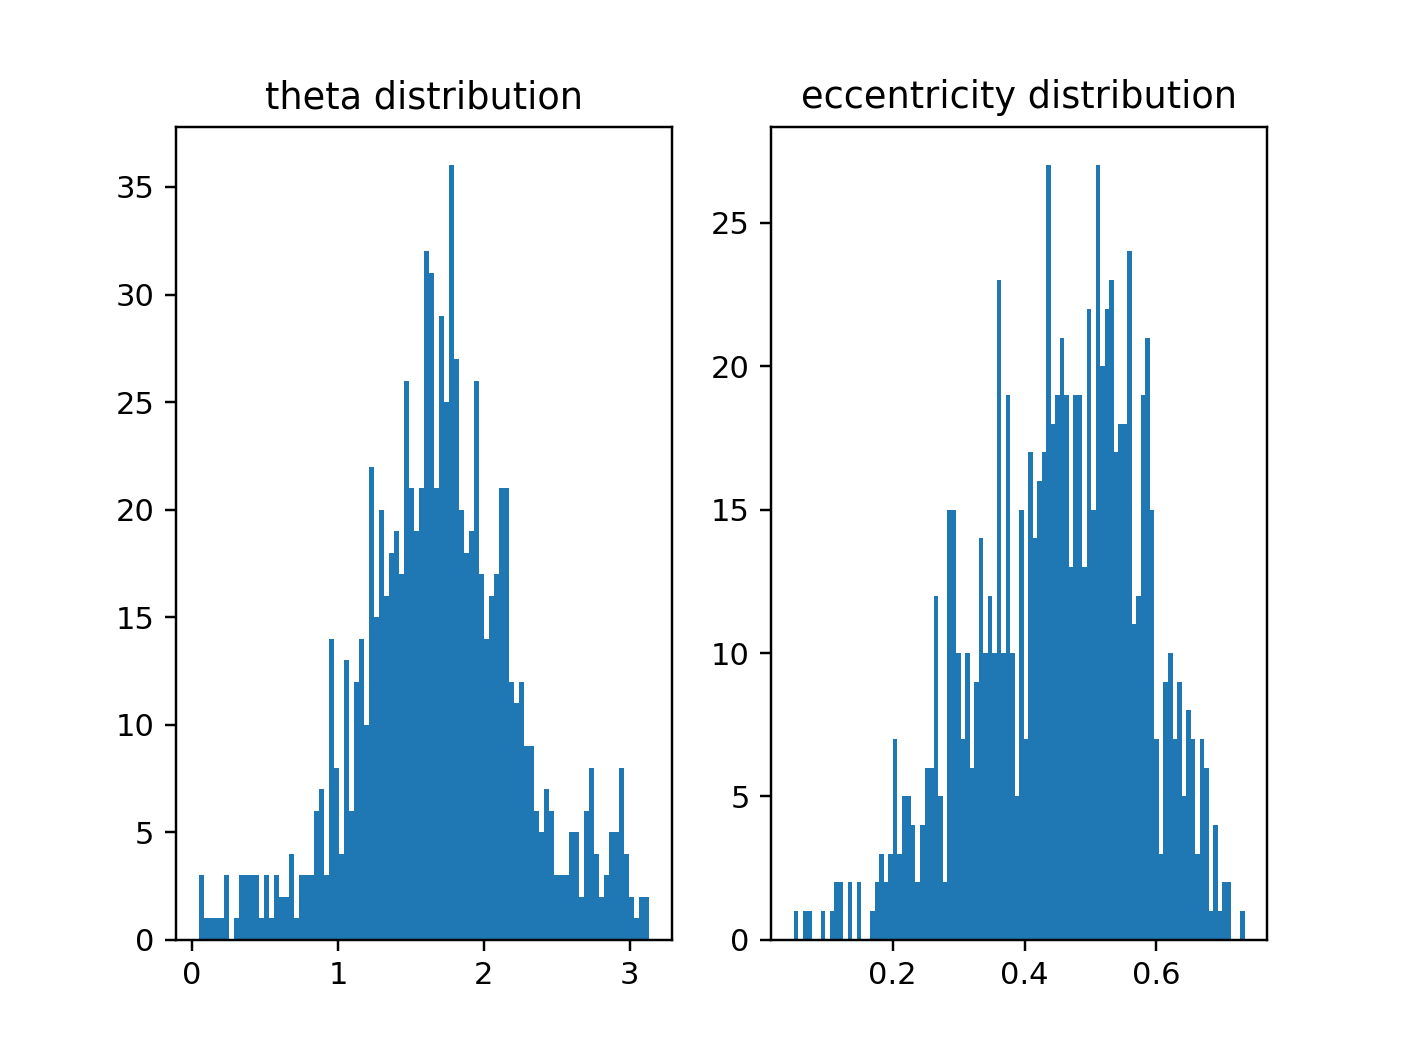

In [5]:
# make overlay images of the orientation on the FN and collagen images
overlay_fig, overlay_ax = plt.subplots()
overlay_ax.imshow(FN[0,7,:,:], cmap= 'Greys_r', vmin=27, vmax=1168)
overlay_ax.quiver(x[mask_plane7],y[mask_plane7],u[mask_plane7],v[mask_plane7], color='yellow')
overlay_fig.show()
# overlay_fig.savefig('Overlay FN with Orientations.eps', format='eps')

overlay2_fig, overlay2_ax = plt.subplots()
overlay2_ax.imshow(Collagen[0,7,:,:], cmap= 'Greys_r', vmin=27, vmax=1168)
overlay2_ax.quiver(xc[mask_plane7],yc[mask_plane7],uc[mask_plane7],vc[mask_plane7], color='red')
overlay2_fig.show()
# overlay2_fig.savefig('Overlay Collagen with Orientations.eps', format='eps')

theta_ecc_fig, theta_ecc_ax = plt.subplots(ncols=2)
theta_ecc_ax[0].hist(FN_theta_plane7, bins = 90)
theta_ecc_ax[0].set_title('theta distribution')
theta_ecc_ax[1].hist(FN_ecc_plane7, bins = 100)
theta_ecc_ax[1].set_title('eccentricity distribution')
theta_ecc_fig.show()
